In [2]:
import os, cv2, numpy as np, json
from tqdm import tqdm
from sklearn.cluster import MiniBatchKMeans
from joblib import dump
from pathlib import Path
from skimage.feature import hog
import random
import matplotlib.pyplot as plt
from skimage import exposure
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import numpy as np
import wandb

# Method 1

Sampling SIFT for codebook:  13%|█▎        | 306/2374 [00:10<01:12, 28.69it/s]


Collected descriptors for codebook: (200251, 128)


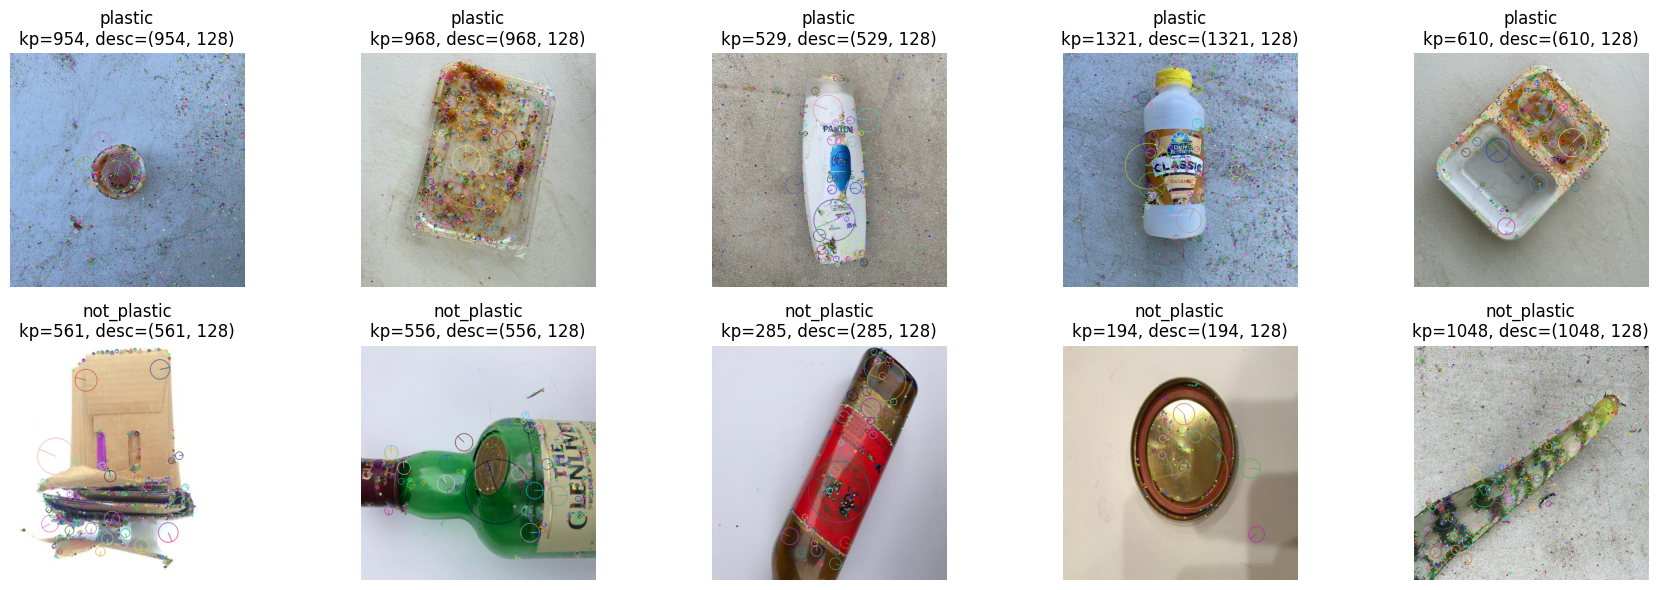

Saved codebook to: D:\SEM 7\CVProject\features_bovw_sift


train BoVW saved: (2374, 2048) labels: (2374,)


val BoVW saved: (510, 2048) labels: (510,)


test BoVW saved: (507, 2048) labels: (507,)


In [ ]:

# --- SIFT → BoVW codebook + per-image histograms ---
BASE = r"D:\SEM 7\CVProject\pretraning_dataset"
SPLITS = ["train", "val", "test"]
CLASSES = ["plastic", "not_plastic"]

# BoVW config (reduced k to avoid ultra-sparse histograms)
K = 256                          # <= try 256 first; you can also try 512 later
MAX_DESC_PER_IMG = 2000          # cap SIFT descriptors per image (for sampling)
MAX_DESCS_TOTAL = 200_000        # total descriptors to sample for k-means
BATCH_SIZE = 10_000              # MiniBatchKMeans batch size
RANDOM_STATE = 42

OUT_DIR = Path(BASE).parent / "features_bovw_sift"
OUT_DIR.mkdir(parents=True, exist_ok=True)

def list_images(root):
    return [str(Path(root, f)) for f in os.listdir(root)
            if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.tif','.tiff','.webp'))]

# Create one SIFT instance (minor speed boost)
_sift = cv2.SIFT_create()
def sift_descriptors(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    kps, desc = _sift.detectAndCompute(gray, None)
    return desc  # shape (n_kp, 128) or None

# 1) Collect SIFT descriptors from TRAIN only for codebook (shuffle to avoid bias)
train_paths = []
for c in CLASSES:
    cdir = Path(BASE, "train", c)
    if cdir.is_dir():
        train_paths += list_images(cdir)

rng = np.random.default_rng(RANDOM_STATE)
rng.shuffle(train_paths)  # <-- important so early break doesn't bias toward one class/source

all_desc = []
for p in tqdm(train_paths, desc="Sampling SIFT for codebook"):
    img = cv2.imread(p)
    if img is None:
        continue
    d = sift_descriptors(img)
    if d is None or len(d) == 0:
        continue
    # cap per image
    if len(d) > MAX_DESC_PER_IMG:
        idx = rng.choice(len(d), size=MAX_DESC_PER_IMG, replace=False)
        d = d[idx]
    all_desc.append(d)
    if sum(len(x) for x in all_desc) >= MAX_DESCS_TOTAL:
        break

if len(all_desc) == 0:
    raise RuntimeError("No SIFT descriptors found in training set. Check your images and paths.")

sampled = np.vstack(all_desc).astype(np.float32)
print("Collected descriptors for codebook:", sampled.shape)

# (Optional visualization) sample keypoints from a few images
sample_visuals = {}
for cls in CLASSES:
    cdir = Path(BASE, "train", cls)
    if cdir.is_dir():
        imgs = list_images(cdir)
        if len(imgs) > 0:
            sample_visuals[cls] = random.sample(imgs, min(5, len(imgs)))

if sample_visuals:
    fig, axes = plt.subplots(len(sample_visuals), 5, figsize=(18, 6))
    for row, cls in enumerate(CLASSES):
        if cls not in sample_visuals: 
            continue
        for col, p in enumerate(sample_visuals[cls]):
            img = cv2.imread(p)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            kps, desc = _sift.detectAndCompute(gray, None)
            img_kp = cv2.drawKeypoints(img, kps, None,
                                       flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            img_rgb = cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB)
            axes[row, col].imshow(img_rgb)
            axes[row, col].set_title(f"{cls}\nkp={len(kps)}, desc={None if desc is None else desc.shape}")
            axes[row, col].axis("off")
    plt.tight_layout()
    plt.show()

# 2) Fit MiniBatchKMeans vocabulary (use deterministic random_state; n_init='auto' for sklearn>=1.4)
kmeans = MiniBatchKMeans(n_clusters=K, batch_size=BATCH_SIZE, random_state=RANDOM_STATE, n_init='auto', verbose=0)
kmeans.fit(sampled)
dump(kmeans, OUT_DIR / f"kmeans_k{K}.joblib")
with open(OUT_DIR / "bovw_config.json", "w") as f:
    json.dump({"K": K, "MAX_DESC_PER_IMG": MAX_DESC_PER_IMG}, f, indent=2)
print("Saved codebook to:", OUT_DIR)

# 3) Build BoVW histograms for ALL images (train/val/test) and save
for split in SPLITS:
    X = []
    y = []
    paths = []
    for cls_idx, c in enumerate(CLASSES):
        cdir = Path(BASE, split, c)
        if not cdir.is_dir():
            continue
        imgs = list_images(cdir)
        for p in tqdm(imgs, desc=f"BoVW {split}/{c}", leave=False):
            img = cv2.imread(p)
            if img is None:
                continue
            d = sift_descriptors(img)
            if d is None or len(d) == 0:
                hist = np.zeros(K, dtype=np.float32)
            else:
                idx = kmeans.predict(d)
                hist = np.bincount(idx, minlength=K).astype(np.float32)
                # L1 normalize (TF-IDF will be applied later, after we stack all histograms)
                s = hist.sum()
                if s > 0:
                    hist /= s
            X.append(hist)
            y.append(cls_idx)
            paths.append(p)
    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int32)
    np.save(OUT_DIR / f"X_bovw_{split}.npy", X)
    np.save(OUT_DIR / f"y_{split}.npy", y)
    with open(OUT_DIR / f"paths_{split}.json", "w") as f:
        json.dump(paths, f, indent=2)
    print(split, "BoVW saved:", X.shape, "labels:", y.shape)


train HOG saved: (2374, 34596) labels: (2374,)


val HOG saved: (510, 34596) labels: (510,)


test HOG saved: (507, 34596) labels: (507,)


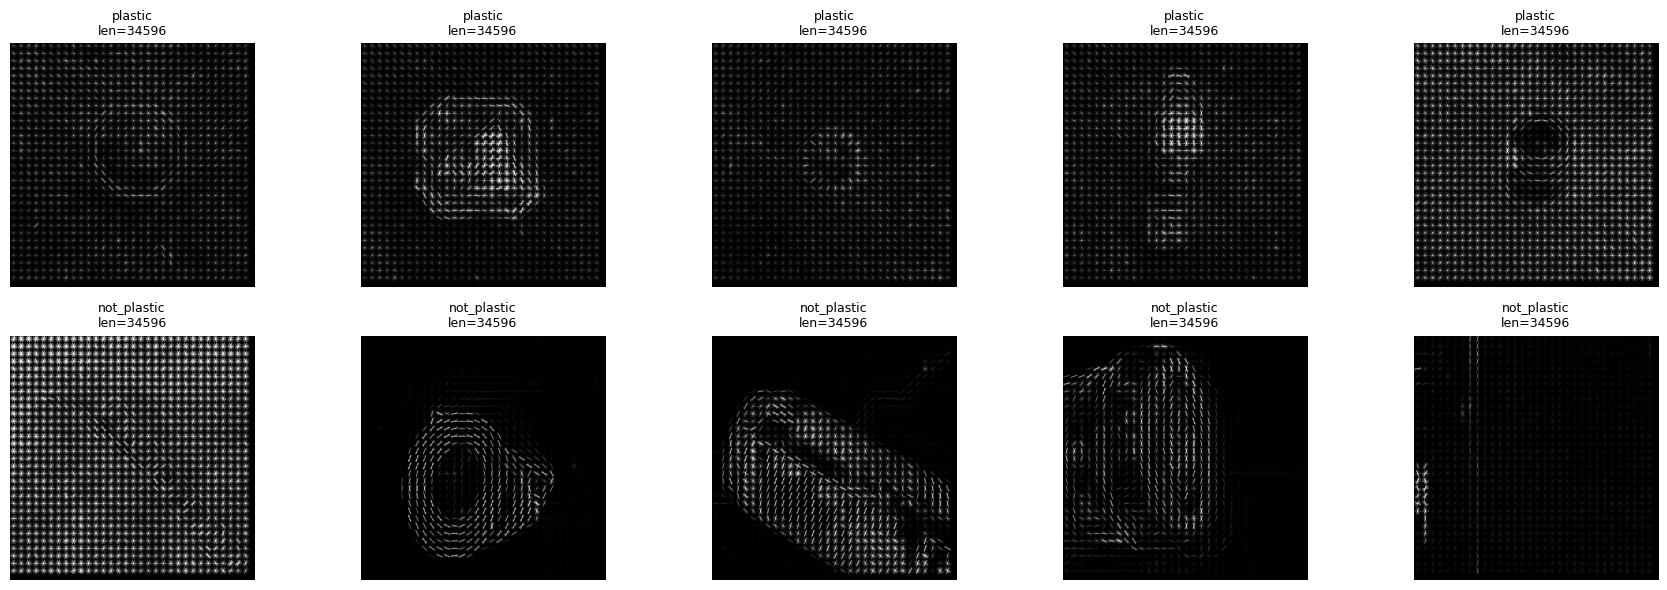

In [ ]:


# --- HOG extraction (baseline only; not used in BoVW+TF-IDF+Linear SVM pipeline) ---
BASE = r"D:\SEM 7\CVProject\pretraning_dataset"
SPLITS = ["train", "val", "test"]
CLASSES = ["plastic", "not_plastic"]

# Ensure fixed-size inputs so feature length is consistent across images
RESIZE = (256, 256)

HOG_PARAMS = dict(
    orientations=9,
    pixels_per_cell=(16, 16),
    cells_per_block=(2, 2),
    block_norm="L2-Hys",
    feature_vector=True
)

OUT_DIR = Path(BASE).parent / "features_hog"
OUT_DIR.mkdir(parents=True, exist_ok=True)
with open(OUT_DIR / "hog_config.json", "w") as f:
    json.dump({
        "RESIZE": list(RESIZE),
        **{k: (v if not isinstance(v, tuple) else list(v)) for k, v in HOG_PARAMS.items()}
    }, f, indent=2)

def list_images(root):
    return sorted([str(Path(root, f)) for f in os.listdir(root)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'))])

# --------- Feature extraction ----------
for split in SPLITS:
    X, y, paths = [], [], []
    for cls_idx, c in enumerate(CLASSES):
        cdir = Path(BASE, split, c)
        if not cdir.is_dir():
            continue
        imgs = list_images(cdir)
        for p in tqdm(imgs, desc=f"HOG {split}/{c}", unit="img", leave=False):
            img = cv2.imread(p)
            if img is None:
                continue
            img = cv2.resize(img, RESIZE, interpolation=cv2.INTER_AREA)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            feat = hog(gray, **HOG_PARAMS)
            X.append(feat.astype(np.float32))
            y.append(cls_idx)
            paths.append(p)

    if len(X) == 0:
        print(f"{split}: no HOG features found.")
        continue

    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int32)
    np.save(OUT_DIR / f"X_hog_{split}.npy", X)
    np.save(OUT_DIR / f"y_{split}.npy", y)
    with open(OUT_DIR / f"paths_{split}.json", "w") as f:
        json.dump(paths, f, indent=2)
    print(split, "HOG saved:", X.shape, "labels:", y.shape)

# --------- Visual check ----------
sample_visuals = {}
for cls in CLASSES:
    cdir = Path(BASE, "train", cls)
    if cdir.is_dir():
        imgs = list_images(cdir)
        sample_visuals[cls] = random.sample(imgs, min(5, len(imgs))) if len(imgs) > 0 else []

rows, cols = len(CLASSES), 5
fig, axes = plt.subplots(rows, cols, figsize=(18, 6))

for row, cls in enumerate(CLASSES):
    picks = sample_visuals.get(cls, [])
    for col in range(cols):
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis("off")
        if col >= len(picks):
            continue
        p = picks[col]
        img = cv2.imread(p)
        if img is None:
            continue
        img = cv2.resize(img, RESIZE, interpolation=cv2.INTER_AREA)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        feat, hog_image = hog(gray, visualize=True, **HOG_PARAMS)
        hog_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        ax.imshow(hog_rescaled, cmap="gray")
        ax.set_title(f"{cls}\nlen={len(feat)}", fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:

# --- HSV color histogram per image (baseline; do NOT concat with BoVW for the first pipeline) ---
BASE = r"D:\SEM 7\CVProject\pretraning_dataset"
SPLITS = ["train", "val", "test"]
CLASSES = ["plastic", "not_plastic"]

# Keep bins; add a fixed resize so features are comparable across images
H_BINS, S_BINS, V_BINS = 12, 4, 3
OUT_DIM = H_BINS * S_BINS + V_BINS  # 48 + 3 = 51
RESIZE = (256, 256)

OUT_DIR = Path(BASE).parent / "features_hsv"
OUT_DIR.mkdir(parents=True, exist_ok=True)
with open(OUT_DIR / "hsv_config.json", "w") as f:
    json.dump(
        {"H_BINS": H_BINS, "S_BINS": S_BINS, "V_BINS": V_BINS, "RESIZE": list(RESIZE)},
        f, indent=2
    )

def list_images(root):
    return sorted([str(Path(root, f)) for f in os.listdir(root)
                   if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.tif','.tiff','.webp'))])

def hsv_feature(img_bgr):
    # resize (keeps statistics stable across different image sizes)
    img_bgr = cv2.resize(img_bgr, RESIZE, interpolation=cv2.INTER_AREA)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)
    # HS 2D hist (bins order: [H, S])
    hs_hist = cv2.calcHist([H, S], [0, 1], None, [H_BINS, S_BINS], [0, 180, 0, 256])
    hs_hist = hs_hist.astype(np.float32)
    # V 1D hist
    v_hist = cv2.calcHist([V], [0], None, [V_BINS], [0, 256]).astype(np.float32).flatten()
    # L1 normalize each, then concat
    hs_sum = hs_hist.sum()
    if hs_sum > 0:
        hs_hist /= hs_sum
    v_sum = v_hist.sum()
    if v_sum > 0:
        v_hist /= v_sum
    return np.concatenate([hs_hist.flatten(), v_hist], axis=0)  # (51,)

# --------- Feature extraction ----------
for split in SPLITS:
    X, y, paths = [], [], []
    for cls_idx, c in enumerate(CLASSES):
        cdir = Path(BASE, split, c)
        if not cdir.is_dir():
            continue
        imgs = list_images(cdir)
        for p in tqdm(imgs, desc=f"HSV {split}/{c}", unit="img", leave=False):
            img = cv2.imread(p)
            if img is None:
                continue
            feat = hsv_feature(img)
            X.append(feat.astype(np.float32))
            y.append(cls_idx)
            paths.append(p)

    if len(X) == 0:
        print(f"{split}: no HSV features found.")
        continue

    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int32)
    np.save(OUT_DIR / f"X_hsv_{split}.npy", X)
    np.save(OUT_DIR / f"y_{split}.npy", y)
    with open(OUT_DIR / f"paths_{split}.json", "w") as f:
        json.dump(paths, f, indent=2)
    print(split, "HSV saved:", X.shape, "labels:", y.shape)

# --- HSV heatmap visualization (plastic vs non-plastic) ---
FEAT_DIR = str(Path(BASE).parent / "features_hsv")
X = np.load(os.path.join(FEAT_DIR, "X_hsv_train.npy"))  # (N, 51)
y = np.load(os.path.join(FEAT_DIR, "y_train.npy"))      # (N,)

# class indices follow CLASSES order
plastic_feats = X[y == 0]
nonplastic_feats = X[y == 1]

# HS = first 48 bins; reshape correctly to (H_BINS, S_BINS) then transpose for (S,H) display
plastic_hs = plastic_feats[:, :H_BINS*S_BINS]
nonplastic_hs = nonplastic_feats[:, :H_BINS*S_BINS]

plastic_hs_mean = plastic_hs.mean(axis=0).reshape(H_BINS, S_BINS).T   # (S_BINS, H_BINS)
nonplastic_hs_mean = nonplastic_hs.mean(axis=0).reshape(H_BINS, S_BINS).T

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
im1 = axes[0].imshow(plastic_hs_mean, cmap="inferno", aspect="auto")
axes[0].set_title("Plastic - Mean HS distribution")
axes[0].set_xlabel("Hue bins (0–180°)")
axes[0].set_ylabel("Saturation bins (low→high)")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(nonplastic_hs_mean, cmap="inferno", aspect="auto")
axes[1].set_title("Non-Plastic - Mean HS distribution")
axes[1].set_xlabel("Hue bins (0–180°)")
axes[1].set_ylabel("Saturation bins (low→high)")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


train HSV saved: (2374, 51) labels: (2374,)


val HSV saved: (510, 51) labels: (510,)


test HSV saved: (507, 51) labels: (507,)


In [ ]:
# --- CONCATENATE BoVW (512) + HOG (~34596) + HSV (51), then scale ---
BASE = r"D:\SEM 7\CVProject\pretraning_dataset"

DIR_BOVW = str(Path(BASE).parent / "features_bovw_sift")
DIR_HOG  = str(Path(BASE).parent / "features_hog")
DIR_HSV  = str(Path(BASE).parent / "features_hsv")

def load_split(split):
    X_bovw = np.load(os.path.join(DIR_BOVW, f"X_bovw_{split}.npy"))   # (N,512)
    X_hog  = np.load(os.path.join(DIR_HOG,  f"X_hog_{split}.npy"))    # (N,~34596)
    X_hsv  = np.load(os.path.join(DIR_HSV,  f"X_hsv_{split}.npy"))    # (N,51)
    y_b    = np.load(os.path.join(DIR_BOVW, f"y_{split}.npy"))        # (N,)
    y_h    = np.load(os.path.join(DIR_HOG,  f"y_{split}.npy"))
    y_s    = np.load(os.path.join(DIR_HSV,  f"y_{split}.npy"))

    # sanity: labels must match order/length
    assert (y_b == y_h).all() and (y_b == y_s).all(), f"Label mismatch in {split}"
    # concatenate in agreed order
    X = np.hstack([X_bovw, X_hog, X_hsv]).astype(np.float32)
    y = y_b.astype(np.int32)
    return X, y

# Load all splits
X_train, y_train = load_split("train")
X_val,   y_val   = load_split("val")
X_test,  y_test  = load_split("test")

print("Shapes:")
print("  train:", X_train.shape, y_train.shape)
print("  val  :", X_val.shape,   y_val.shape)
print("  test :", X_test.shape,  y_test.shape)

# Scale (z-score) so blocks have comparable ranges
scaler = StandardScaler(with_mean=False)  # sparse-friendly behavior; features are non-negative hist-like
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

print("Scaled shapes:", X_train_s.shape, X_val_s.shape, X_test_s.shape)

# Optional: save scaler for later inference
from joblib import dump
ART_DIR = Path(BASE).parent / "artifacts_rf"
ART_DIR.mkdir(parents=True, exist_ok=True)
dump(scaler, ART_DIR / "scaler_rf.joblib")


Shapes:
  train: (2374, 36695) (2374,)
  val  : (510, 36695) (510,)
  test : (507, 36695) (507,)
Scaled shapes: (2374, 36695) (510, 36695) (507, 36695)


['D:\\SEM 7\\CVProject\\artifacts_rf\\scaler_rf.joblib']

In [30]:
# --- Train Random Forest + validation eval (plastic-positive, with threshold sweep) ---
use_wandb = True
run = None
if use_wandb:
    try:
        import wandb
        wandb.login()
        run = wandb.init(
            project="cv-plastic-pretraining",
            config={
                "model": "RandomForest",
                "n_estimators": 800,                 # a bit more trees for stability
                "max_depth": None,
                "class_weight": "balanced",          # <— change 1: stronger balancing
                "features": ["BoVW512","HOG~34600","HSV51"],
                "scaler": "StandardScaler(with_mean=False)",
            },
            name="rf_bovw-hog-hsv",
            reinit=True
        )
    except Exception as e:
        print("wandb disabled:", e)
        use_wandb = False

# Train RF
rf = RandomForestClassifier(
    n_estimators=800,
    max_depth=None,
    class_weight="balanced",      # <— change 1 mirrored here
    n_jobs=-1,
    oob_score=True,
    random_state=42
)

print("Fitting RandomForest...")
rf.fit(X_train_s, y_train)

# OOB check
if hasattr(rf, "oob_score_"):
    print(f"OOB score: {rf.oob_score_:.4f}")
    if use_wandb and run:
        wandb.log({"oob_score": rf.oob_score_})

# ===== VALIDATION with PLASTIC probability & THRESHOLD SWEEP =====
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np

classes_list = rf.classes_.tolist()
try:
    plastic_idx = classes_list.index(0)  # 0 = plastic in your labels
except ValueError:
    raise RuntimeError(f"Expected label '0' (plastic) in rf.classes_, found: {classes_list}")

val_proba_plastic = rf.predict_proba(X_val_s)[:, plastic_idx]

def sweep_thresholds(y_true, probs, n=61):
    ths = np.linspace(0.05, 0.95, n)
    best = None
    rows = []
    for t in ths:
        preds = np.where(probs >= t, 0, 1)  # 0=plastic, 1=not_plastic
        p, r, f1, _ = precision_recall_fscore_support(y_true, preds, average="binary",
                                                      pos_label=0, zero_division=0)
        rows.append((t, p, r, f1))
        score = (p, f1)  # prioritize plastic precision, tie-break by F1
        if best is None or score > (best[1], best[3]):
            best = (t, p, r, f1)
    return np.array(rows), best

rows, best = sweep_thresholds(y_val, val_proba_plastic, n=91)
best_t, best_p, best_r, best_f1 = best
print(f"\nChosen τ on val (plastic prob): {best_t:.2f}  -> P_plastic={best_p:.3f}, R_plastic={best_r:.3f}, F1_plastic={best_f1:.3f}")

# Metrics at chosen τ (VAL)
val_pred_labels = np.where(val_proba_plastic >= best_t, 0, 1)
print("\nValidation @ chosen τ (plastic positive):")
print(classification_report(y_val, val_pred_labels, target_names=["plastic","not_plastic"]))
print("Confusion matrix (val):\n", confusion_matrix(y_val, val_pred_labels))

if use_wandb and run:
    acc = (val_pred_labels == y_val).mean()
    wandb.log({"val_tau": float(best_t),
               "val_acc": acc,
               "val_precision_plastic": best_p,
               "val_recall_plastic": best_r,
               "val_f1_plastic": best_f1})

# Save model
from joblib import dump
dump(rf, ART_DIR / "rf_model.joblib")
print("Saved RF to:", ART_DIR / "rf_model.joblib")


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Fitting RandomForest...
OOB score: 0.8993

Chosen τ on val (plastic prob): 0.05  -> P_plastic=0.313, R_plastic=0.468, F1_plastic=0.375

Validation @ chosen τ (plastic positive):
              precision    recall  f1-score   support

     plastic       0.31      0.47      0.38       222
 not_plastic       0.34      0.21      0.26       288

    accuracy                           0.32       510
   macro avg       0.33      0.34      0.32       510
weighted avg       0.33      0.32      0.31       510

Confusion matrix (val):
 [[104 118]
 [228  60]]
Saved RF to: D:\SEM 7\CVProject\artifacts_rf\rf_model.joblib


In [23]:
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np

# plastic is label 0 in your y's
plastic_idx = rf.classes_.tolist().index(0)
val_proba_plastic = rf.predict_proba(X_val_s)[:, plastic_idx]

def choose_tau(y_true, probs, target_precision=0.75, n=201):
    ths = np.linspace(0.0, 1.0, n)
    best_f1 = (-1, 0.0)  # (f1, tau)
    best_prec_target = None  # (recall, tau, precision, f1)
    for t in ths:
        preds = np.where(probs >= t, 0, 1)  # 0=plastic, 1=not_plastic
        p, r, f1, _ = precision_recall_fscore_support(y_true, preds, average="binary", pos_label=0, zero_division=0)
        if f1 > best_f1[0]:
            best_f1 = (f1, t)
        if p >= target_precision:
            if best_prec_target is None or r > best_prec_target[0]:
                best_prec_target = (r, t, p, f1)
    return {"best_f1": best_f1, "best_prec_target": best_prec_target}

choice = choose_tau(y_val, val_proba_plastic, target_precision=0.75, n=201)
(best_f1, tau_f1) = choice["best_f1"]
if choice["best_prec_target"] is not None:
    r_best, tau_prec, p_best, f1_at_prec = choice["best_prec_target"]
    print(f"Chosen τ for precision≥0.75: τ={tau_prec:.3f}  P={p_best:.3f}  R={r_best:.3f}  F1={f1_at_prec:.3f}")
    chosen_tau = tau_prec
else:
    print(f"No τ reached precision≥0.75. Using F1-optimal τ={tau_f1:.3f}  F1={best_f1:.3f}")
    chosen_tau = tau_f1

# Evaluate at chosen τ
val_pred = np.where(val_proba_plastic >= chosen_tau, 0, 1)
print("\nValidation @ chosen τ:")
print(classification_report(y_val, val_pred, target_names=["plastic","not_plastic"]))
print("Confusion matrix (val):\n", confusion_matrix(y_val, val_pred))


No τ reached precision≥0.75. Using F1-optimal τ=0.015  F1=0.607

Validation @ chosen τ:
              precision    recall  f1-score   support

     plastic       0.44      0.99      0.61       222
 not_plastic       0.73      0.03      0.05       288

    accuracy                           0.45       510
   macro avg       0.58      0.51      0.33       510
weighted avg       0.60      0.45      0.29       510

Confusion matrix (val):
 [[219   3]
 [280   8]]


# Method 2

Sampling SIFT for codebook:   0%|          | 0/2374 [00:00<?, ?it/s]

Sampling SIFT for codebook: 100%|██████████| 2374/2374 [01:01<00:00, 38.48it/s]


Collected descriptors for codebook: (1992424, 128)


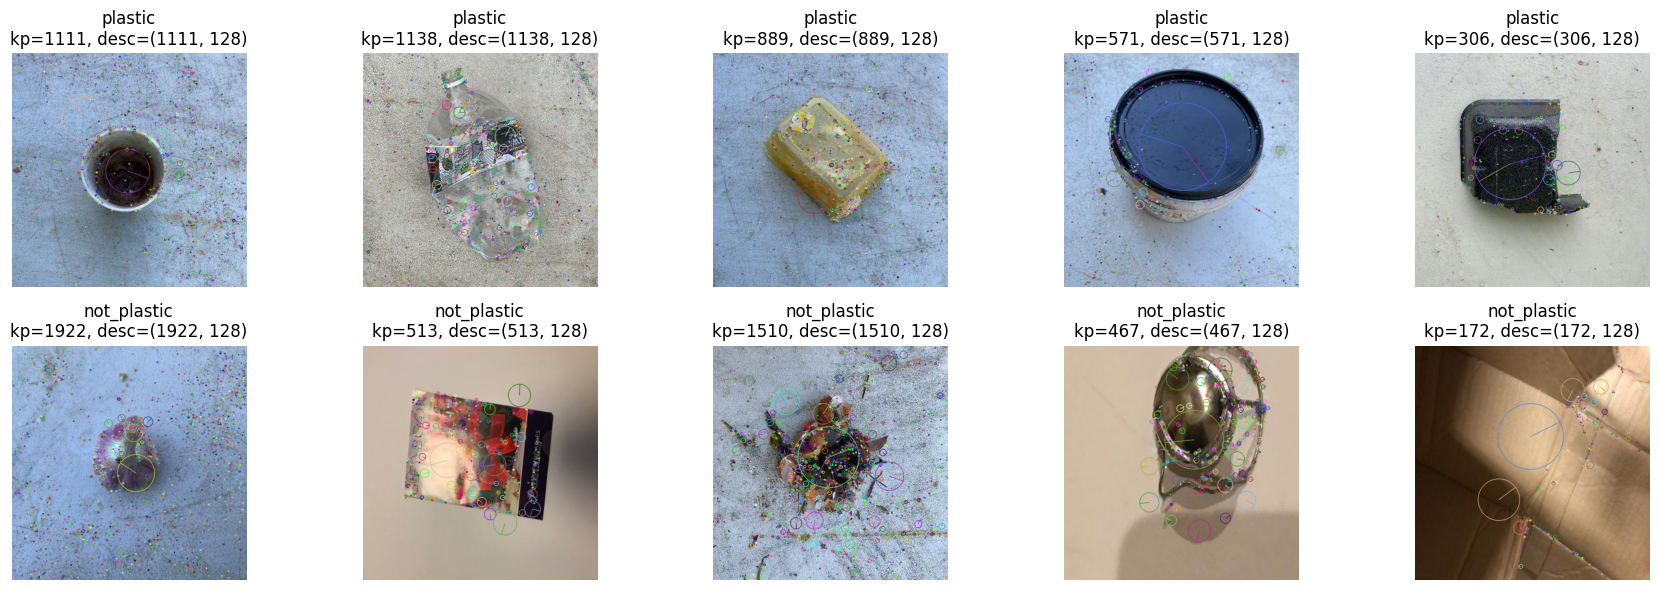

Saved codebook to: D:\SEM 7\CVProject\features_bovw_sift


train BoVW saved: (2374, 256) labels: (2374,)


val BoVW saved: (510, 256) labels: (510,)


test BoVW saved: (507, 256) labels: (507,)


In [3]:
# --- SIFT → BoVW codebook + per-image histograms ---
BASE = r"D:\SEM 7\CVProject\pretraning_dataset"
SPLITS = ["train", "val", "test"]
CLASSES = ["plastic", "not_plastic"]

# BoVW config (reduced k to avoid ultra-sparse histograms)
K = 256                          
MAX_DESC_PER_IMG = 20000          # cap SIFT descriptors per image (for sampling)
MAX_DESCS_TOTAL = 20000000        # total descriptors to sample for k-means
BATCH_SIZE = 100000               # MiniBatchKMeans batch size
RANDOM_STATE = 42

OUT_DIR = Path(BASE).parent / "features_bovw_sift"
OUT_DIR.mkdir(parents=True, exist_ok=True)

def list_images(root):
    return [str(Path(root, f)) for f in os.listdir(root)
            if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.tif','.tiff','.webp'))]

# Create one SIFT instance (minor speed boost)
_sift = cv2.SIFT_create()
def sift_descriptors(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    kps, desc = _sift.detectAndCompute(gray, None)
    return desc  # shape (n_kp, 128) or None

# 1) Collect SIFT descriptors from TRAIN only for codebook (shuffle to avoid bias)
train_paths = []
for c in CLASSES:
    cdir = Path(BASE, "train", c)
    if cdir.is_dir():
        train_paths += list_images(cdir)

rng = np.random.default_rng(RANDOM_STATE)
rng.shuffle(train_paths)  # <-- important so early break doesn't bias toward one class/source

all_desc = []
for p in tqdm(train_paths, desc="Sampling SIFT for codebook"):
    img = cv2.imread(p)
    if img is None:
        continue
    d = sift_descriptors(img)
    if d is None or len(d) == 0:
        continue
    # cap per image
    if len(d) > MAX_DESC_PER_IMG:
        idx = rng.choice(len(d), size=MAX_DESC_PER_IMG, replace=False)
        d = d[idx]
    all_desc.append(d)
    if sum(len(x) for x in all_desc) >= MAX_DESCS_TOTAL:
        break

if len(all_desc) == 0:
    raise RuntimeError("No SIFT descriptors found in training set. Check your images and paths.")

sampled = np.vstack(all_desc).astype(np.float32)
print("Collected descriptors for codebook:", sampled.shape)

# (Optional visualization) sample keypoints from a few images
sample_visuals = {}
for cls in CLASSES:
    cdir = Path(BASE, "train", cls)
    if cdir.is_dir():
        imgs = list_images(cdir)
        if len(imgs) > 0:
            sample_visuals[cls] = random.sample(imgs, min(5, len(imgs)))

if sample_visuals:
    fig, axes = plt.subplots(len(sample_visuals), 5, figsize=(18, 6))
    for row, cls in enumerate(CLASSES):
        if cls not in sample_visuals: 
            continue
        for col, p in enumerate(sample_visuals[cls]):
            img = cv2.imread(p)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            kps, desc = _sift.detectAndCompute(gray, None)
            img_kp = cv2.drawKeypoints(img, kps, None,
                                       flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            img_rgb = cv2.cvtColor(img_kp, cv2.COLOR_BGR2RGB)
            axes[row, col].imshow(img_rgb)
            axes[row, col].set_title(f"{cls}\nkp={len(kps)}, desc={None if desc is None else desc.shape}")
            axes[row, col].axis("off")
    plt.tight_layout()
    plt.show()

# 2) Fit MiniBatchKMeans vocabulary (use deterministic random_state; n_init='auto' for sklearn>=1.4)
kmeans = MiniBatchKMeans(n_clusters=K, batch_size=BATCH_SIZE, random_state=RANDOM_STATE, n_init='auto', verbose=0)
kmeans.fit(sampled)
dump(kmeans, OUT_DIR / f"kmeans_k{K}.joblib")
with open(OUT_DIR / "bovw_config.json", "w") as f:
    json.dump({"K": K, "MAX_DESC_PER_IMG": MAX_DESC_PER_IMG}, f, indent=2)
print("Saved codebook to:", OUT_DIR)

# 3) Build BoVW histograms for ALL images (train/val/test) and save
for split in SPLITS:
    X = []
    y = []
    paths = []
    for cls_idx, c in enumerate(CLASSES):
        cdir = Path(BASE, split, c)
        if not cdir.is_dir():
            continue
        imgs = list_images(cdir)
        for p in tqdm(imgs, desc=f"BoVW {split}/{c}", leave=False):
            img = cv2.imread(p)
            if img is None:
                continue
            d = sift_descriptors(img)
            if d is None or len(d) == 0:
                hist = np.zeros(K, dtype=np.float32)
            else:
                idx = kmeans.predict(d)
                hist = np.bincount(idx, minlength=K).astype(np.float32)
                # L1 normalize (TF-IDF will be applied later, after we stack all histograms)
                s = hist.sum()
                if s > 0:
                    hist /= s
            X.append(hist)
            y.append(cls_idx)
            paths.append(p)
    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int32)
    np.save(OUT_DIR / f"X_bovw_{split}.npy", X)
    np.save(OUT_DIR / f"y_{split}.npy", y)
    with open(OUT_DIR / f"paths_{split}.json", "w") as f:
        json.dump(paths, f, indent=2)
    print(split, "BoVW saved:", X.shape, "labels:", y.shape)


train HOG saved: (2374, 8100) labels: (2374,)


val HOG saved: (510, 8100) labels: (510,)


test HOG saved: (507, 8100) labels: (507,)


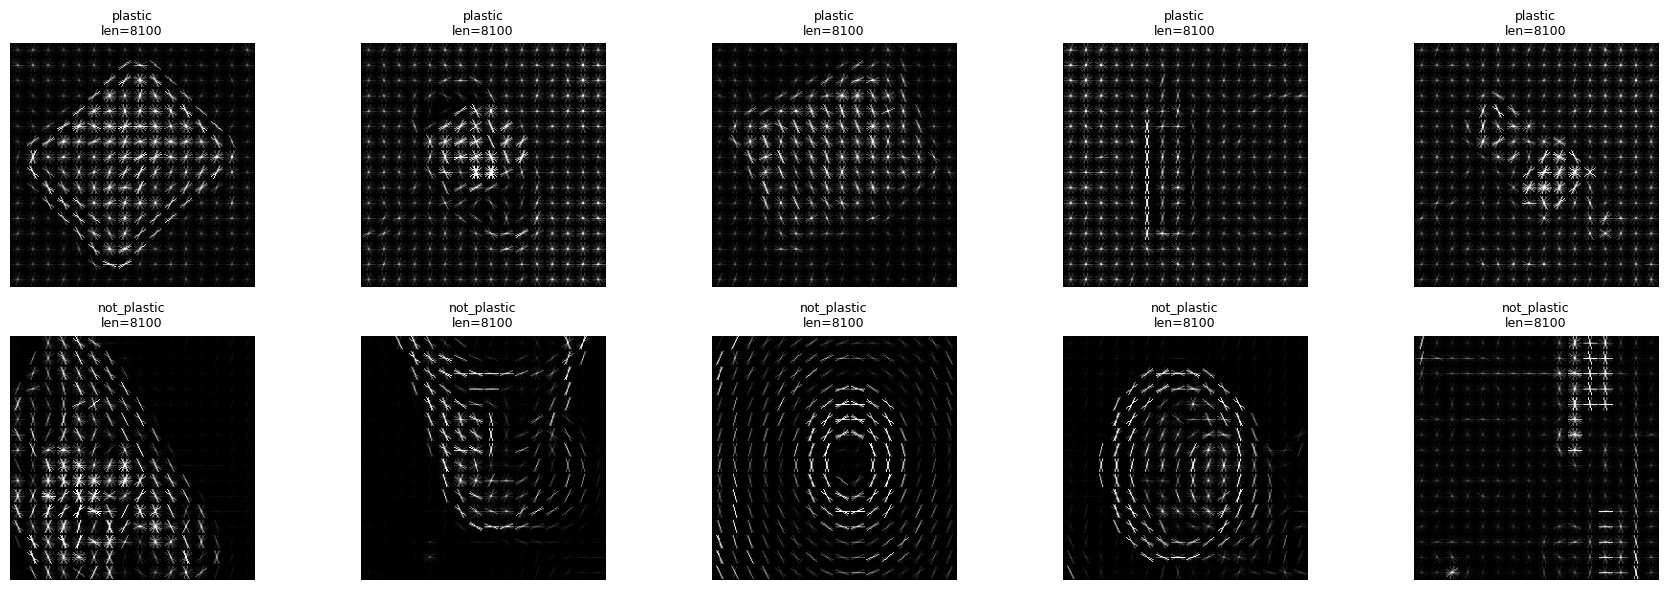

In [4]:
# --- HOG extraction (baseline only; not used in BoVW+TF-IDF+Linear SVM pipeline) ---
BASE = r"D:\SEM 7\CVProject\pretraning_dataset"
SPLITS = ["train", "val", "test"]
CLASSES = ["plastic", "not_plastic"]

# Ensure fixed-size inputs so feature length is consistent across images
RESIZE = (256, 256)

HOG_PARAMS = dict(
    orientations=9,
    pixels_per_cell=(16, 16),
    cells_per_block=(2, 2),
    block_norm="L2-Hys",
    feature_vector=True
)

OUT_DIR = Path(BASE).parent / "features_hog"
OUT_DIR.mkdir(parents=True, exist_ok=True)
with open(OUT_DIR / "hog_config.json", "w") as f:
    json.dump({
        "RESIZE": list(RESIZE),
        **{k: (v if not isinstance(v, tuple) else list(v)) for k, v in HOG_PARAMS.items()}
    }, f, indent=2)

def list_images(root):
    return sorted([str(Path(root, f)) for f in os.listdir(root)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'))])

# --------- Feature extraction ----------
for split in SPLITS:
    X, y, paths = [], [], []
    for cls_idx, c in enumerate(CLASSES):
        cdir = Path(BASE, split, c)
        if not cdir.is_dir():
            continue
        imgs = list_images(cdir)
        for p in tqdm(imgs, desc=f"HOG {split}/{c}", unit="img", leave=False):
            img = cv2.imread(p)
            if img is None:
                continue
            img = cv2.resize(img, RESIZE, interpolation=cv2.INTER_AREA)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            feat = hog(gray, **HOG_PARAMS)
            X.append(feat.astype(np.float32))
            y.append(cls_idx)
            paths.append(p)

    if len(X) == 0:
        print(f"{split}: no HOG features found.")
        continue

    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int32)
    np.save(OUT_DIR / f"X_hog_{split}.npy", X)
    np.save(OUT_DIR / f"y_{split}.npy", y)
    with open(OUT_DIR / f"paths_{split}.json", "w") as f:
        json.dump(paths, f, indent=2)
    print(split, "HOG saved:", X.shape, "labels:", y.shape)

# --------- Visual check ----------
sample_visuals = {}
for cls in CLASSES:
    cdir = Path(BASE, "train", cls)
    if cdir.is_dir():
        imgs = list_images(cdir)
        sample_visuals[cls] = random.sample(imgs, min(5, len(imgs))) if len(imgs) > 0 else []

rows, cols = len(CLASSES), 5
fig, axes = plt.subplots(rows, cols, figsize=(18, 6))

for row, cls in enumerate(CLASSES):
    picks = sample_visuals.get(cls, [])
    for col in range(cols):
        ax = axes[row, col] if rows > 1 else axes[col]
        ax.axis("off")
        if col >= len(picks):
            continue
        p = picks[col]
        img = cv2.imread(p)
        if img is None:
            continue
        img = cv2.resize(img, RESIZE, interpolation=cv2.INTER_AREA)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        feat, hog_image = hog(gray, visualize=True, **HOG_PARAMS)
        hog_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
        ax.imshow(hog_rescaled, cmap="gray")
        ax.set_title(f"{cls}\nlen={len(feat)}", fontsize=9)

plt.tight_layout()
plt.show()


train HSV saved: (2374, 51) labels: (2374,)


val HSV saved: (510, 51) labels: (510,)


test HSV saved: (507, 51) labels: (507,)


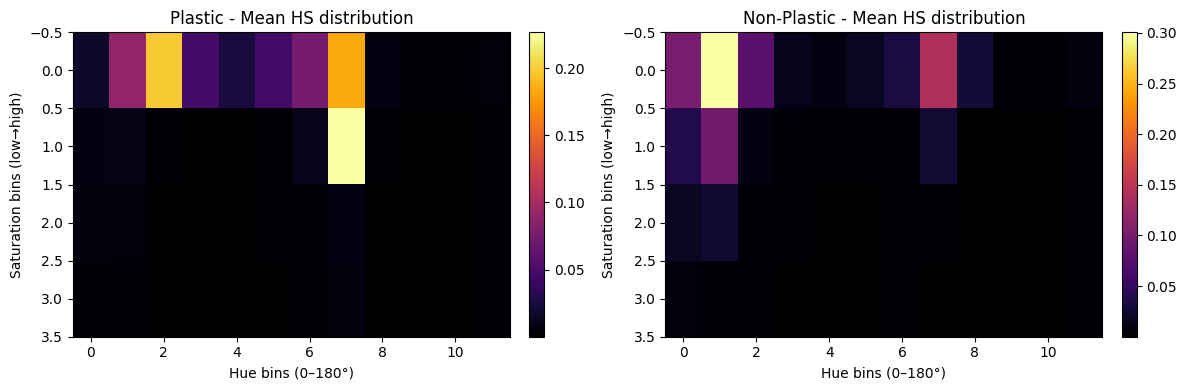

In [5]:
# --- HSV color histogram per image (baseline; do NOT concat with BoVW for the first pipeline) ---
BASE = r"D:\SEM 7\CVProject\pretraning_dataset"
SPLITS = ["train", "val", "test"]
CLASSES = ["plastic", "not_plastic"]

# Keep bins; add a fixed resize so features are comparable across images
H_BINS, S_BINS, V_BINS = 12, 4, 3
OUT_DIM = H_BINS * S_BINS + V_BINS  # 48 + 3 = 51
RESIZE = (256, 256)

OUT_DIR = Path(BASE).parent / "features_hsv"
OUT_DIR.mkdir(parents=True, exist_ok=True)
with open(OUT_DIR / "hsv_config.json", "w") as f:
    json.dump(
        {"H_BINS": H_BINS, "S_BINS": S_BINS, "V_BINS": V_BINS, "RESIZE": list(RESIZE)},
        f, indent=2
    )

def list_images(root):
    return sorted([str(Path(root, f)) for f in os.listdir(root)
                   if f.lower().endswith(('.jpg','.jpeg','.png','.bmp','.tif','.tiff','.webp'))])

def hsv_feature(img_bgr):
    # resize (keeps statistics stable across different image sizes)
    img_bgr = cv2.resize(img_bgr, RESIZE, interpolation=cv2.INTER_AREA)
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    H, S, V = cv2.split(hsv)
    # HS 2D hist (bins order: [H, S])
    hs_hist = cv2.calcHist([H, S], [0, 1], None, [H_BINS, S_BINS], [0, 180, 0, 256])
    hs_hist = hs_hist.astype(np.float32)
    # V 1D hist
    v_hist = cv2.calcHist([V], [0], None, [V_BINS], [0, 256]).astype(np.float32).flatten()
    # L1 normalize each, then concat
    hs_sum = hs_hist.sum()
    if hs_sum > 0:
        hs_hist /= hs_sum
    v_sum = v_hist.sum()
    if v_sum > 0:
        v_hist /= v_sum
    return np.concatenate([hs_hist.flatten(), v_hist], axis=0)  # (51,)

# --------- Feature extraction ----------
for split in SPLITS:
    X, y, paths = [], [], []
    for cls_idx, c in enumerate(CLASSES):
        cdir = Path(BASE, split, c)
        if not cdir.is_dir():
            continue
        imgs = list_images(cdir)
        for p in tqdm(imgs, desc=f"HSV {split}/{c}", unit="img", leave=False):
            img = cv2.imread(p)
            if img is None:
                continue
            feat = hsv_feature(img)
            X.append(feat.astype(np.float32))
            y.append(cls_idx)
            paths.append(p)

    if len(X) == 0:
        print(f"{split}: no HSV features found.")
        continue

    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int32)
    np.save(OUT_DIR / f"X_hsv_{split}.npy", X)
    np.save(OUT_DIR / f"y_{split}.npy", y)
    with open(OUT_DIR / f"paths_{split}.json", "w") as f:
        json.dump(paths, f, indent=2)
    print(split, "HSV saved:", X.shape, "labels:", y.shape)

# --- HSV heatmap visualization (plastic vs non-plastic) ---
FEAT_DIR = str(Path(BASE).parent / "features_hsv")
X = np.load(os.path.join(FEAT_DIR, "X_hsv_train.npy"))  # (N, 51)
y = np.load(os.path.join(FEAT_DIR, "y_train.npy"))      # (N,)

# class indices follow CLASSES order
plastic_feats = X[y == 0]
nonplastic_feats = X[y == 1]

# HS = first 48 bins; reshape correctly to (H_BINS, S_BINS) then transpose for (S,H) display
plastic_hs = plastic_feats[:, :H_BINS*S_BINS]
nonplastic_hs = nonplastic_feats[:, :H_BINS*S_BINS]

plastic_hs_mean = plastic_hs.mean(axis=0).reshape(H_BINS, S_BINS).T   # (S_BINS, H_BINS)
nonplastic_hs_mean = nonplastic_hs.mean(axis=0).reshape(H_BINS, S_BINS).T

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
im1 = axes[0].imshow(plastic_hs_mean, cmap="inferno", aspect="auto")
axes[0].set_title("Plastic - Mean HS distribution")
axes[0].set_xlabel("Hue bins (0–180°)")
axes[0].set_ylabel("Saturation bins (low→high)")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(nonplastic_hs_mean, cmap="inferno", aspect="auto")
axes[1].set_title("Non-Plastic - Mean HS distribution")
axes[1].set_xlabel("Hue bins (0–180°)")
axes[1].set_ylabel("Saturation bins (low→high)")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


In [6]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize
import numpy as np
from pathlib import Path
from joblib import dump
import os, json

# --- For the first pipeline, DO NOT concatenate HOG/HSV. Use BoVW only + TF-IDF (+ Hellinger norm). ---
BASE = r"D:\SEM 7\CVProject\pretraning_dataset"
DIR_BOVW = str(Path(BASE).parent / "features_bovw_sift")

def load_bovw(split):
    X = np.load(os.path.join(DIR_BOVW, f"X_bovw_{split}.npy"))   # (N, K) L1-normalized per image
    y = np.load(os.path.join(DIR_BOVW, f"y_{split}.npy"))        # (N,)
    return X.astype(np.float32), y.astype(np.int32)

X_train, y_train = load_bovw("train")
X_val,   y_val   = load_bovw("val")
X_test,  y_test  = load_bovw("test")

print("BoVW shapes before TF-IDF:")
print("  train:", X_train.shape, y_train.shape)
print("  val  :", X_val.shape,   y_val.shape)
print("  test :", X_test.shape,  y_test.shape)

# --- TF-IDF weighting (fit on train ONLY, then transform all splits) ---
# Use norm=None here because we'll apply the Hellinger (sqrt + L2) ourselves afterward.
tfidf = TfidfTransformer(norm=None, use_idf=True, sublinear_tf=False)
X_train_tfidf = tfidf.fit_transform(X_train).astype(np.float32)  # sparse
X_val_tfidf   = tfidf.transform(X_val).astype(np.float32)
X_test_tfidf  = tfidf.transform(X_test).astype(np.float32)

print("BoVW shapes after TF-IDF (no norm):")
print("  train:", X_train_tfidf.shape, y_train.shape)
print("  val  :", X_val_tfidf.shape,   y_val.shape)
print("  test :", X_test_tfidf.shape,  y_test.shape)

# --- Hellinger normalization: element-wise sqrt then L2-normalize ---
def hellinger_norm(X):
    X = X.tocsr(copy=True)
    X.data = np.sqrt(X.data, dtype=np.float32)
    return normalize(X, norm='l2', copy=False)

X_train_s = hellinger_norm(X_train_tfidf)
X_val_s   = hellinger_norm(X_val_tfidf)
X_test_s  = hellinger_norm(X_test_tfidf)

print("BoVW shapes after Hellinger (sqrt+L2):")
print("  train:", X_train_s.shape, y_train.shape)
print("  val  :", X_val_s.shape,   y_val.shape)
print("  test :", X_test_s.shape,  y_test.shape)

# Save transformer for inference
ART_DIR = Path(BASE).parent / "artifacts_bovw_tfidf"
ART_DIR.mkdir(parents=True, exist_ok=True)
dump(tfidf, ART_DIR / "tfidf_bovw.joblib")

# (Optional) record K used
cfg_path = Path(DIR_BOVW) / "bovw_config.json"
if cfg_path.exists():
    with open(cfg_path, "r") as f:
        cfg = json.load(f)
    with open(ART_DIR / "bovw_used.json", "w") as f:
        json.dump(cfg, f, indent=2)


BoVW shapes before TF-IDF:
  train: (2374, 256) (2374,)
  val  : (510, 256) (510,)
  test : (507, 256) (507,)
BoVW shapes after TF-IDF (no norm):
  train: (2374, 256) (2374,)
  val  : (510, 256) (510,)
  test : (507, 256) (507,)
BoVW shapes after Hellinger (sqrt+L2):
  train: (2374, 256) (2374,)
  val  : (510, 256) (510,)
  test : (507, 256) (507,)


In [7]:
# --- Train Linear SVM + Calibration on BoVW+TF-IDF (after Hellinger); choose τ via PR curve ---
import os, json
import numpy as np
from pathlib import Path
from tqdm import tqdm
from joblib import dump
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, auc

# Expect from previous step: X_train_s, y_train, X_val_s, y_val, X_test_s, y_test

# ==== Configs you may tweak ====
SVM_C = 0.5                        # try: 0.25, 0.5, 1.0, 2.0, 4.0
CALIB_METHOD = "sigmoid"           # try "isotonic" as well (cv=3 kept)
CALIB_CV = 3
USE_WANDB = True

# ==== Weights & Biases (guarded) ====
wandb = None
run = None
if USE_WANDB:
    try:
        import wandb as _wandb
        wandb = _wandb
        wandb.login()
        run = wandb.init(
            project="cv-plastic-pretraining",
            config={
                "pipeline": "BoVW -> L1 -> TF-IDF -> sqrt+L2(Hellinger) -> LinearSVM -> Calibrated(%s)" % CALIB_METHOD,
                "features": ["BoVW_TFIDF_Hellinger"],
                "svm_C": SVM_C,
                "svm_class_weight": "balanced",
                "calibration": CALIB_METHOD,
                "calibration_cv": CALIB_CV,
            },
            name=f"svm_bovw_tfidf_hell_{CALIB_METHOD}_C{SVM_C}",
            reinit=True
        )
    except Exception as e:
        print("wandb disabled:", e)
        wandb = None
        run = None

# ==== Base linear SVM (no probas) + probability calibration wrapper ====
base_svm = LinearSVC(C=SVM_C, class_weight="balanced", random_state=42)
# sklearn >=1.4 uses 'estimator'
clf = CalibratedClassifierCV(estimator=base_svm, method=CALIB_METHOD, cv=CALIB_CV)

print("Fitting LinearSVM + calibration...")
clf.fit(X_train_s, y_train)

# ---- VALIDATION: calibrated probabilities for class 'plastic' (label 0) ----
probs_val = clf.predict_proba(X_val_s)  # (N, 2)
classes_list = clf.classes_.tolist()
try:
    plastic_idx = classes_list.index(0)  # 0 = plastic
except ValueError:
    raise RuntimeError(f"Expected label '0' (plastic) in clf.classes_, found: {classes_list}")

plastic_scores = probs_val[:, plastic_idx]

# Precision-Recall curve for plastic as positive class
prec, rec, ths = precision_recall_curve(y_val, plastic_scores, pos_label=0)
pr_auc = auc(rec, prec)

def f1_from_pr(p, r):
    d = (p + r)
    return (2 * p * r / d) if d > 0 else 0.0

best = {"tau": 0.5, "P": 0.0, "R": 0.0, "F1": -1.0}
for t in tqdm(np.r_[ths, [1.0]], desc="Sweeping thresholds", unit="τ"):
    preds = np.where(plastic_scores >= t, 0, 1)  # 0=plastic, 1=not_plastic
    tp = np.sum((y_val == 0) & (preds == 0))
    fp = np.sum((y_val == 1) & (preds == 0))
    fn = np.sum((y_val == 0) & (preds == 1))
    P = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    R = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    F1 = f1_from_pr(P, R)
    if F1 > best["F1"]:
        best.update({"tau": float(t), "P": float(P), "R": float(R), "F1": float(F1)})

best_t = best["tau"]

# Final VAL metrics at chosen τ
val_pred_labels = np.where(plastic_scores >= best_t, 0, 1)
report = classification_report(y_val, val_pred_labels, target_names=["plastic","not_plastic"], digits=3)
cm = confusion_matrix(y_val, val_pred_labels)

print(f"\nChosen τ on val (plastic prob): {best_t:.3f}  -> "
      f"P_plastic={best['P']:.3f}, R_plastic={best['R']:.3f}, F1_plastic={best['F1']:.3f}")
print("\nValidation @ chosen τ (plastic positive):")
print(report)
print("Confusion matrix (val):\n", cm)

if wandb is not None and run is not None:
    wandb.log({
        "val_tau": float(best_t),
        "val_pr_auc": float(pr_auc),
        "val_precision_plastic": float(best["P"]),
        "val_recall_plastic": float(best["R"]),
        "val_f1_plastic": float(best["F1"]),
        "val_confusion_matrix": wandb.plot.confusion_matrix(
            probs=None,
            y_true=y_val.tolist(),
            preds=val_pred_labels.tolist(),
            class_names=["plastic", "not_plastic"]
        )
    })

# ---- Save calibrated model & threshold ----
BASE = r"D:\SEM 7\CVProject\pretraning_dataset"
ART_DIR = Path(BASE).parent / "artifacts_svm_bovw_tfidf"
ART_DIR.mkdir(parents=True, exist_ok=True)
dump(clf, ART_DIR / f"svm_bovw_tfidf_calibrated_{CALIB_METHOD}_C{SVM_C}.joblib")
with open(ART_DIR / "decision_threshold.json", "w") as f:
    json.dump({"tau_plastic": best_t}, f, indent=2)
print("Saved calibrated SVM and threshold to:", ART_DIR)


wandb: Currently logged in as: diptosen2017 (diptosen2017-svkm-s-narsee-monjee-institute-of-managemen) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Fitting LinearSVM + calibration...


Sweeping thresholds: 100%|██████████| 511/511 [00:00<00:00, 78540.41τ/s]


Chosen τ on val (plastic prob): 0.054  -> P_plastic=0.511, R_plastic=0.932, F1_plastic=0.660

Validation @ chosen τ (plastic positive):
              precision    recall  f1-score   support

     plastic      0.511     0.932     0.660       222
 not_plastic      0.857     0.312     0.458       288

    accuracy                          0.582       510
   macro avg      0.684     0.622     0.559       510
weighted avg      0.707     0.582     0.546       510

Confusion matrix (val):
 [[207  15]
 [198  90]]


Saved calibrated SVM and threshold to: D:\SEM 7\CVProject\artifacts_svm_bovw_tfidf
